In [1]:
!pip install -U setuptools

  Using cached setuptools-78.1.0-py3-none-any.whl.metadata (6.6 kB)
Using cached setuptools-78.1.0-py3-none-any.whl (1.3 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 78.0.2
    Uninstalling setuptools-78.0.2:
      Successfully uninstalled setuptools-78.0.2


In [2]:
import triton

In [22]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
)
import transformers

from datasets import load_dataset
from composer import Trainer    
from composer.models import HuggingFaceModel, ComposerModel

import torch
from torch.utils.data import DataLoader

from tqdm import tqdm

model_name = "roneneldan/TinyStories-1M"
config = AutoConfig.from_pretrained(model_name)
config.max_position_embeddings = 512
model = AutoModelForCausalLM.from_config(config, attn_implementation='flash_attention_2').to('cuda')
sum(p.numel() for p in model.parameters() if p.requires_grad)

3647680

In [23]:
max_vocab_size = 2048

In [ ]:
train_data = load_dataset('roneneldan/TinyStories', split='train').with_format('np')
val_data = load_dataset('roneneldan/TinyStories', split='validation').with_format('np')

In [25]:
def remove_rows_with_keyword(dataset, keyword):
    """
    Remove rows from a dataset where the 'text' field contains the specified keyword.
    
    Args:
        dataset: A Hugging Face dataset
        keyword: String to search for in the text
        
    Returns:
        Filtered dataset without rows containing the keyword
    """
    filtered_indices = [i for i, example in enumerate(dataset) if keyword not in example['text']]
    return dataset.select(filtered_indices)

# Example usage:
keywords_to_filter = ["drown", "violent", "died", "kill", "bad ending"]
filtered_train_data = train_data
for keyword in keywords_to_filter:
    # filtered_train_data = remove_rows_with_keyword(filtered_train_data, keyword)
    pass
print(f"Original dataset size: {len(train_data)}, Filtered dataset size: {len(filtered_train_data)}")

Original dataset size: 2119719, Filtered dataset size: 2119719


In [26]:
def get_training_corpus():
    for start_idx in range(0, len(train_data), 10000):
        patch = train_data[start_idx: start_idx+10000]
        yield patch['text']
        

In [27]:
corpus = get_training_corpus()
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [28]:
# tokenizer = tokenizer.train_new_from_iterator(corpus, vocab_size=max_vocab_size)
# tokenizer.save_pretrained(f'./training/tokenizer/{max_vocab_size}')

In [29]:
tokenizer = tokenizer.from_pretrained(f'./training/tokenizer/{max_vocab_size}')

In [30]:
model.resize_token_embeddings(tokenizer.vocab_size)

Embedding(2048, 64)

In [31]:
model = torch.compile(model)
model

OptimizedModule(
  (_orig_mod): GPTNeoForCausalLM(
    (transformer): GPTNeoModel(
      (wte): Embedding(2048, 64)
      (wpe): Embedding(512, 64)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-7): 8 x GPTNeoBlock(
          (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attn): GPTNeoAttention(
            (attention): GPTNeoFlashAttention2(
              (attn_dropout): Dropout(p=0.0, inplace=False)
              (resid_dropout): Dropout(p=0.0, inplace=False)
              (k_proj): Linear(in_features=64, out_features=64, bias=False)
              (v_proj): Linear(in_features=64, out_features=64, bias=False)
              (q_proj): Linear(in_features=64, out_features=64, bias=False)
              (out_proj): Linear(in_features=64, out_features=64, bias=True)
            )
          )
          (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (mlp): GPTNeoMLP(
            (c_fc): Linear(in_features=64, out_f

In [32]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

562304

In [ ]:
def tokenize(e):
    return tokenizer(e['text'], truncation=True, max_length=512, padding='max_length', return_attention_mask=False)

tokenizer.pad_token = tokenizer.eos_token
# tok_train = train_data.select().map(tokenize, remove_columns=['text'], num_proc=8)
# tok_val  = val_data.select(range(1000)).map(tokenize, remove_columns=['text'], num_proc=8)

# tok_train = filtered_train_data.map(tokenize, remove_columns=['text'], num_proc=8)
# tok_val  = val_data.select(range(1000)).map(tokenize, remove_columns=['text'], num_proc=8)

Map (num_proc=8):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [37]:
tok_train[0]

{'input_ids': [420,
  356,
  12,
  259,
  397,
  446,
  500,
  364,
  595,
  259,
  788,
  307,
  316,
  309,
  758,
  14,
  313,
  703,
  304,
  282,
  1031,
  70,
  470,
  1384,
  84,
  266,
  359,
  342,
  304,
  787,
  304,
  282,
  380,
  287,
  80,
  14,
  364,
  444,
  266,
  948,
  263,
  788,
  307,
  342,
  309,
  365,
  12,
  350,
  338,
  460,
  438,
  87,
  259,
  1838,
  303,
  345,
  309,
  380,
  312,
  84,
  14,
  199,
  199,
  343,
  468,
  266,
  309,
  365,
  265,
  327,
  12,
  329,
  770,
  12,
  335,
  595,
  740,
  788,
  307,
  14,
  1280,
  346,
  948,
  304,
  342,
  518,
  265,
  438,
  87,
  651,
  380,
  312,
  84,
  477,
  865,
  365,
  498,
  265,
  327,
  12,
  329,
  831,
  12,
  364,
  12,
  363,
  471,
  948,
  263,
  788,
  307,
  265,
  1304,
  626,
  380,
  312,
  84,
  415,
  199,
  199,
  52,
  79,
  554,
  12,
  362,
  1654,
  263,
  788,
  307,
  265,
  438,
  87,
  264,
  263,
  1838,
  303,
  345,
  364,
  371,
  380,
  312,
  84,
  14,
  40

In [16]:
max_len = 10
max_pos = []
max_token = []
for k, v in tokenizer.vocab.items():
    if len(k) > max_len:
        max_pos.append(v)
        max_token.append(k)

max_token, max_len, max_pos

(['Ġadventures',
  'Ġremembered',
  'Ġeverything',
  'Ġeverywhere',
  'Ġunderstand',
  '<|endoftext|>'],
 10,
 [1906, 1405, 1601, 1757, 1454, 0])

In [17]:
# !rm -rf ./datasets/tinystories/2048

In [18]:
from streaming import MDSWriter
import numpy as np

out_root = f'./datasets/tinystories/{tokenizer.vocab_size}/'
out_train = out_root + 'train/'
out_val = out_root + 'val/'

columns = {
    'input_ids': 'ndarray:int32',
    # 'attention_mask': 'ndarray:int64',
}
# with MDSWriter(out=out_train, columns=columns, compression='zstd') as writer:
#     for sample in tok_train:
#         sample['input_ids'] = sample['input_ids'].astype(np.int32)
#         writer.write(sample)

# with MDSWriter(out=out_val, columns=columns, compression='zstd') as writer:
#     for sample in tok_val:
#         sample['input_ids'] = sample['input_ids'].astype(np.int32)
#         writer.write(sample)

In [19]:
from streaming import StreamingDataset
bs = 512
tok_train = StreamingDataset(local=out_train, shuffle=True, shuffle_seed=42, batch_size=bs)
tok_val = StreamingDataset(local=out_val, batch_size=bs)

In [20]:
tok_train[0].keys()

dict_keys(['input_ids'])

In [21]:
len(tok_train)

2086250

In [22]:
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(e['input_ids']).to('cuda').to(torch.int64) for e in batch])
    # masks = torch.stack([torch.tensor(e['attention_mask']).to('cuda') for e in batch])
    labels = torch.stack([torch.tensor(e['input_ids']).to('cuda').to(torch.int64) for e in batch])
    return {
        'input_ids': input_ids,
        # 'attention_mask': masks,
        'labels': labels,
        # 'inputs_embeds': None
    }

In [23]:
collator = collate_fn

torch.random.manual_seed(42)
dl_train = DataLoader(tok_train, batch_size=bs, collate_fn=collator)
dl_val = DataLoader(tok_val, batch_size=bs, shuffle=False, collate_fn=collator)

In [24]:
len(dl_train)

4075

In [25]:
class MyModel(HuggingFaceModel):
    def __init__(self, model, tokenizer, metrics=[], use_logits=False):
        super().__init__(model, tokenizer, metrics=metrics, use_logits=use_logits)

    def forward(self, batch):
        return self.model(**batch)
    
    def loss(self, outputs, batch):
        return outputs.loss

In [26]:
batch = next(iter(dl_train))

In [27]:
tokenizer.batch_decode(batch['input_ids'][:2])

['Bobby ran up the hill near his house. He was excited to meet his neighbor. They hadn\'t seen each other in weeks. His neighbor was always so generous with Bobby. He said to himself, "I hope my neighbor is home".\n\nAs he rounded the corner, he saw his neighbor. They were hanging up flowers outside. Bobby waved and said, "hello". His neighbor smiled widely, "Ah, Bobby! I didn\'t know you were coming. Do you want to help me with the flowers?" Bobby was thrilled and said "yes".\n\nFor the next hour, Bobby and his neighbor worked together to hang the flowers. Then, Bobby\'s neighbor said, "Thank you for all your help, Bobby. I have something to give you as a special thank you". Bobby beamed and said, "I love presents! What is it?" His neighbor smiled and said "It\'s a surprise. You have to come back tomorrow and I\'ll give it to you then."\n\nBobby was so excited to find out what his neighbor was getting him that he ran all the way home. The next morning he was back up the hill. When his

In [28]:
from torchmetrics.classification import MulticlassAccuracy
from composer.models.huggingface import HuggingFaceModel
from composer.metrics import CrossEntropy, MaskedAccuracy, LanguageCrossEntropy

metrics = [MaskedAccuracy(ignore_index=0), LanguageCrossEntropy(ignore_index=0)]
# Package as a trainer-friendly Composer model
my_model = MyModel(model, tokenizer, metrics=metrics, use_logits=True)

In [29]:
from composer import Evaluator
eval_evaluator = Evaluator(
    label='acc',
    dataloader=dl_val,
    metric_names=['LanguageCrossEntropy', 'MaskedAccuracy'],
    device_eval_microbatch_size='auto'
)

/usr/lib/python3/dist-packages/composer/core/evaluator.py:147: UserWarning: Setting `device_eval_microbatch_size='auto'` is an experimental feature which may cause uncaught Cuda Out of Memory errors. In this case, please manually set device_eval_microbatch_size explicitly to an integer instead.
  warnings.warn((


In [30]:
from composer.optim import DecoupledAdamW, CosineAnnealingWithWarmupScheduler
from composer.loggers import InMemoryLogger, FileLogger
from composer.metrics import MaskedAccuracy

optim = DecoupledAdamW(my_model.parameters(), lr=4e-4, weight_decay=1e-6)
lr_scheduler = CosineAnnealingWithWarmupScheduler(t_warmup='200ba', t_max="1dur")

logger = InMemoryLogger()

trainer = Trainer(
    model=my_model,
    train_dataloader=dl_train, 
    eval_dataloader=dl_val,
    optimizers=optim,
    schedulers=lr_scheduler,
    max_duration="2ep",
    eval_interval='10ba',
    save_folder="training/pretrain/33M/" + str(optim.param_groups[0]['lr']),
    save_interval="5000ba",
    # save_filename="hf_model.pt",
    save_overwrite=True,
    device_train_microbatch_size='auto',
    loggers=logger,
    device='gpu',
    precision='amp_bf16',
)

/usr/lib/python3/dist-packages/composer/trainer/trainer.py:247: UserWarning: `device_train_microbatch_size='auto'` may potentially fail with unexpected CUDA errors. Auto microbatching attempts to catch CUDA Out of Memory errors and adjust the batch size, but it is possible CUDA will be put into an irrecoverable state due to PyTorch bugs, e.g. integer overflow. In this case, please manually set device_train_microbatch_size explicitly to an integer instead.
  warnings.warn((


In [31]:
import time
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
composer_commit_hash: None
composer_version: 0.30.0
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 1369396387

******************************


train          Epoch   0:    0%|| 0/4075 [00:00<?, ?ba/s]         

W0415 21:08:39.622000 144 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/lib/python3/dist-packages/composer/trainer/trainer.py:368: RuntimeWarning: CUDA out of memory or excessive memory allocation retries detected. Train microbatch size will be decreased from 512 -> 256.
  warnings.warn(
/usr/lib/python3/dist-packages/composer/trainer/trainer.py:368: RuntimeWarning: CUDA out of memory or excessive memory allocation retries detected. Train microbatch size will be decreased from 256 -> 128.
  warnings.warn(


eval           Batch  10:    0%|| 0/2 [00:00<?, ?ba/s]         

/usr/lib/python3/dist-packages/composer/core/data_spec.py:40: UserWarning: Cannot split tensor of length 488 into batches of size 512. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(


eval           Batch  20:    0%|| 0/2 [00:00<?, ?ba/s]         

KeyboardInterrupt: 

In [86]:
logger.data.keys()

dict_keys(['time/epoch', 'time/batch', 'time/sample', 'time/batch_in_epoch', 'time/sample_in_epoch', 'time/token', 'time/token_in_epoch', 'trainer/device_train_microbatch_size', 'loss/train/total', 'metrics/train/MaskedAccuracy', 'metrics/train/LanguageCrossEntropy', 'metrics/eval/MaskedAccuracy', 'metrics/eval/LanguageCrossEntropy'])

In [87]:
def sample(model, tokenizer, prompt, max_length=50, device='cpu'):
    input_ids = tokenizer(prompt, return_tensors='pt').to(device)
    model.eval()
    output = model.generate(**input_ids, max_length=max_length, do_sample=True, top_k=50, top_p=0.95, temperature=0.8)
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [88]:
print(sample(my_model, tokenizer, "Once upon a time", max_length=500, device='cuda:0'))

Once upon a time, there was a little girl named Lily. She loved to play with her toys and run around with her friends. One day, Lily and her friends were playing a game with a ball. They had so much fun that they forgot all about the ball.

Lily said, "I have an idea, but I want to share my ball, we can play with the ball." Her friends said, "Yes, you can share this ball with me!" And they all played with the ball and had a lot of fun.

As the dayed, the friends heard a noise coming from their house. They saw the ball and the ball and had a lot of fun. Lily saw a big, fat cat walking towards them. "Hello, cat!" Lily said. "I'm so happy to have fun with your ball!" The cat took the ball and brought it back to her. Lily felt happy and proud of her new friend.


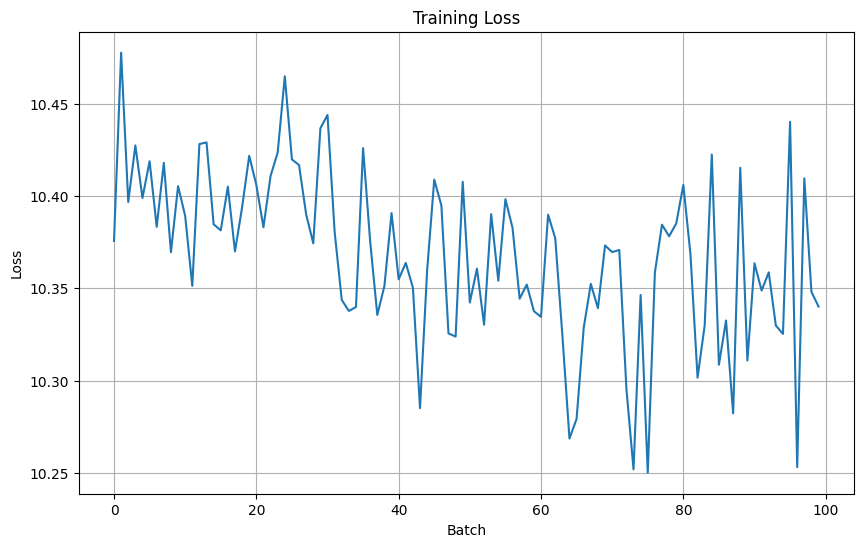

In [91]:
import matplotlib.pyplot as plt

# Extract time and loss values
time_values = []
loss_values = []
for t, v in logger.data['metrics/train/LanguageCrossEntropy']:
    time_values.append(t.batch.value)
    loss_values.append(v.cpu())

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time_values, loss_values)
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)


In [ ]:
metrics[0].sum_loss

In [ ]:
!ls training/pretrain/

In [ ]:
from composer.optim import DecoupledAdamW, CosineAnnealingWithWarmupScheduler
from composer.loggers import InMemoryLogger
from composer.metrics import MaskedAccuracy

optim = DecoupledAdamW(my_model.parameters(), lr=2e-4, weight_decay=0.0001)
lr_scheduler = CosineAnnealingWithWarmupScheduler(t_warmup='200ba', t_max="1dur")

logger = InMemoryLogger()

trainer = Trainer(
    model=my_model,
    train_dataloader=dl_train, 
    eval_dataloader=eval_evaluator,
    optimizers=optim,
    schedulers=lr_scheduler,
    max_duration="2ep",
    eval_interval='1000ba',
    save_folder="training/pretrain/compile/" + str(optim.param_groups[0]['lr']),
    save_interval="5000ba",
    save_filename="hf_model.pt",
    save_overwrite=True,
    device_train_microbatch_size='auto',
    loggers=logger,
    device='gpu',
    precision='amp_bf16',
    autoresume=True,
)